# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    intercepts_and_slopes = {
        "left": {
            "slope": [],
            "intercept": []
        },
        "right": {
            "slope": [],
            "intercept": []
        }
    }
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 - x1:
                slope = (y2 - y1)/(x2 - x1)
                if not slope or abs(slope) < 0.2 or abs(slope) > 0.8:
                    continue
        
                intercept = y1 - slope*x1
                key = 'left'if slope < 0 else 'right'

                intercepts_and_slopes[key]['slope'].append(slope)
                intercepts_and_slopes[key]['intercept'].append(intercept)

    # Find the average Slope
    left_avg_slope = np.mean(intercepts_and_slopes['left']['slope']) if len(intercepts_and_slopes['left']['slope']) else 0
    left_avg_intercept = np.mean(intercepts_and_slopes['left']['intercept']) if len(intercepts_and_slopes['left']['intercept']) else 0
    right_avg_slope = np.mean(intercepts_and_slopes['right']['slope']) if len(intercepts_and_slopes['right']['slope']) else 0
    right_avg_intercept = np.mean(intercepts_and_slopes['right']['intercept']) if len(intercepts_and_slopes['right']['intercept']) else 0
    
    y_min = 330
    y_max = img.shape[0]
    
   # Using y_min and y_max find values of x and extrapolate the line
    if left_avg_slope and right_avg_slope:
        x1_left = (y_max - left_avg_intercept)/left_avg_slope
        y1_left = y_max
        x2_left = (y_min - left_avg_intercept)/left_avg_slope
        y2_left = y_min

        x1_right = (y_max - right_avg_intercept)/right_avg_slope
        y1_right = y_max
        x2_right = (y_min - right_avg_intercept)/right_avg_slope
        y2_right = y_min

        cv2.line(img, (int(x1_left), int(y1_left)), (int(x2_left), int(y2_left)), color, thickness)
        cv2.line(img, (int(x1_right), int(y1_right)), (int(x2_right), int(y2_right)), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Pipeline

In [3]:
def pipeline(image):    
    # Convert to HSL for better color selection
    hsl = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS)

    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hsl, lower, upper)
    
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(hsl, lower, upper)

    # Combined white and yellow mask
    white_yellow_mask = white_mask | yellow_mask
    
    # Applying the mask on original image
    masked = cv2.bitwise_and(image, image, mask=white_yellow_mask)

    # Convert to grayscale
    gray = grayscale(masked)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, 5)


    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, 50, 150)


    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    imshape = image.shape

    # Defining a polygon as region of interest
    vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)


    # Applying Hough Transform
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 15   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 100 # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    
    final_image = weighted_img(line_img, image, α=0.8, β=1., γ=0.)


    return final_image

## Running the pipeline on test images

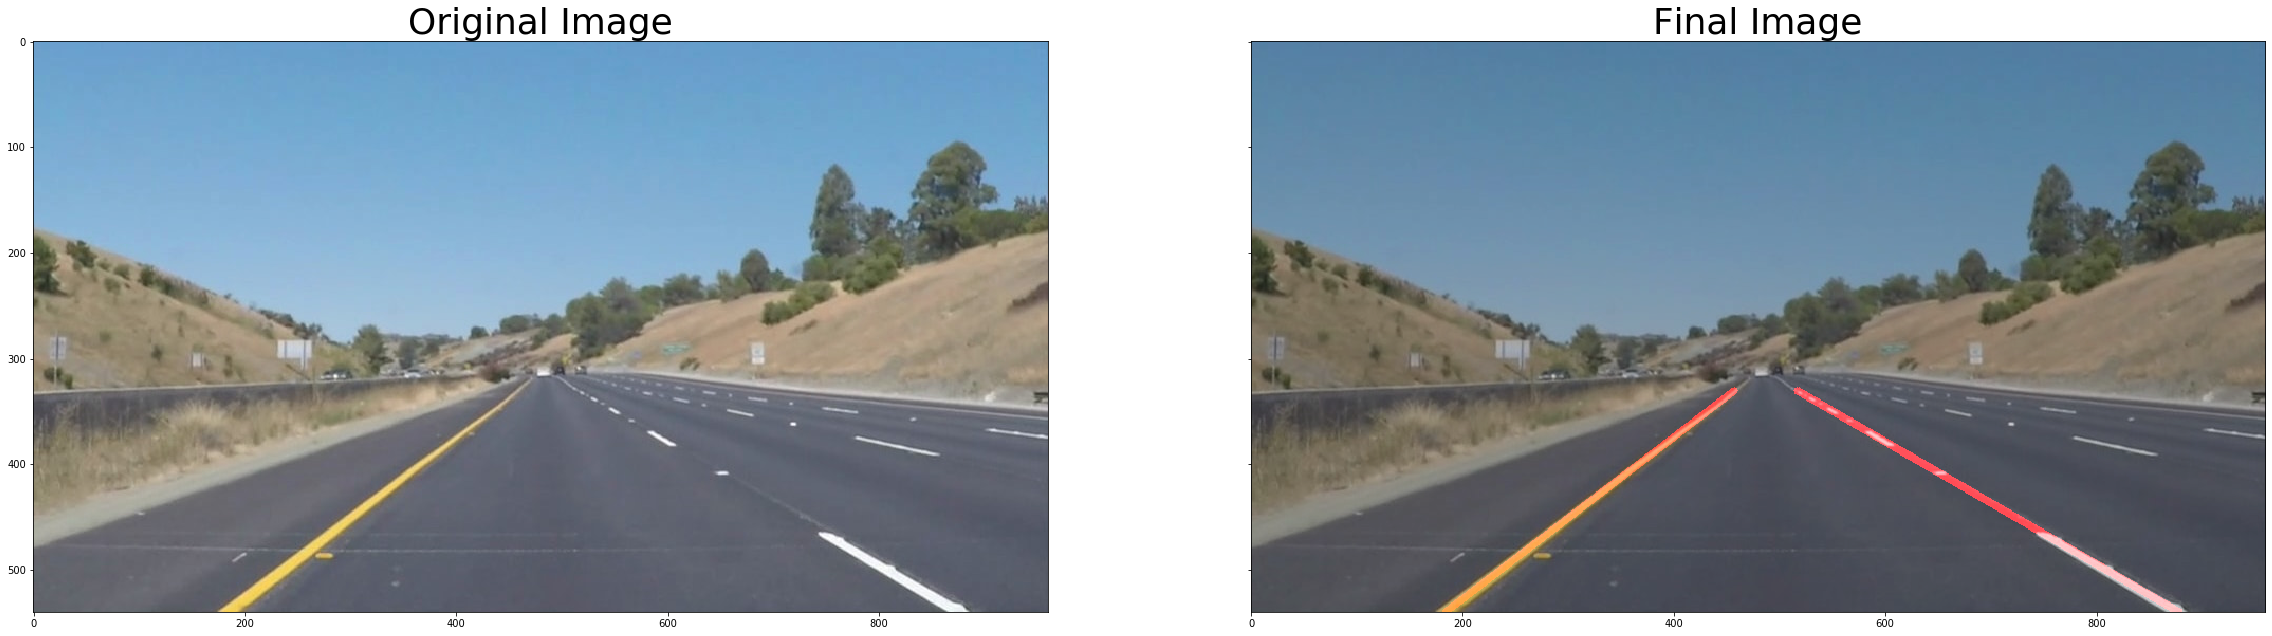

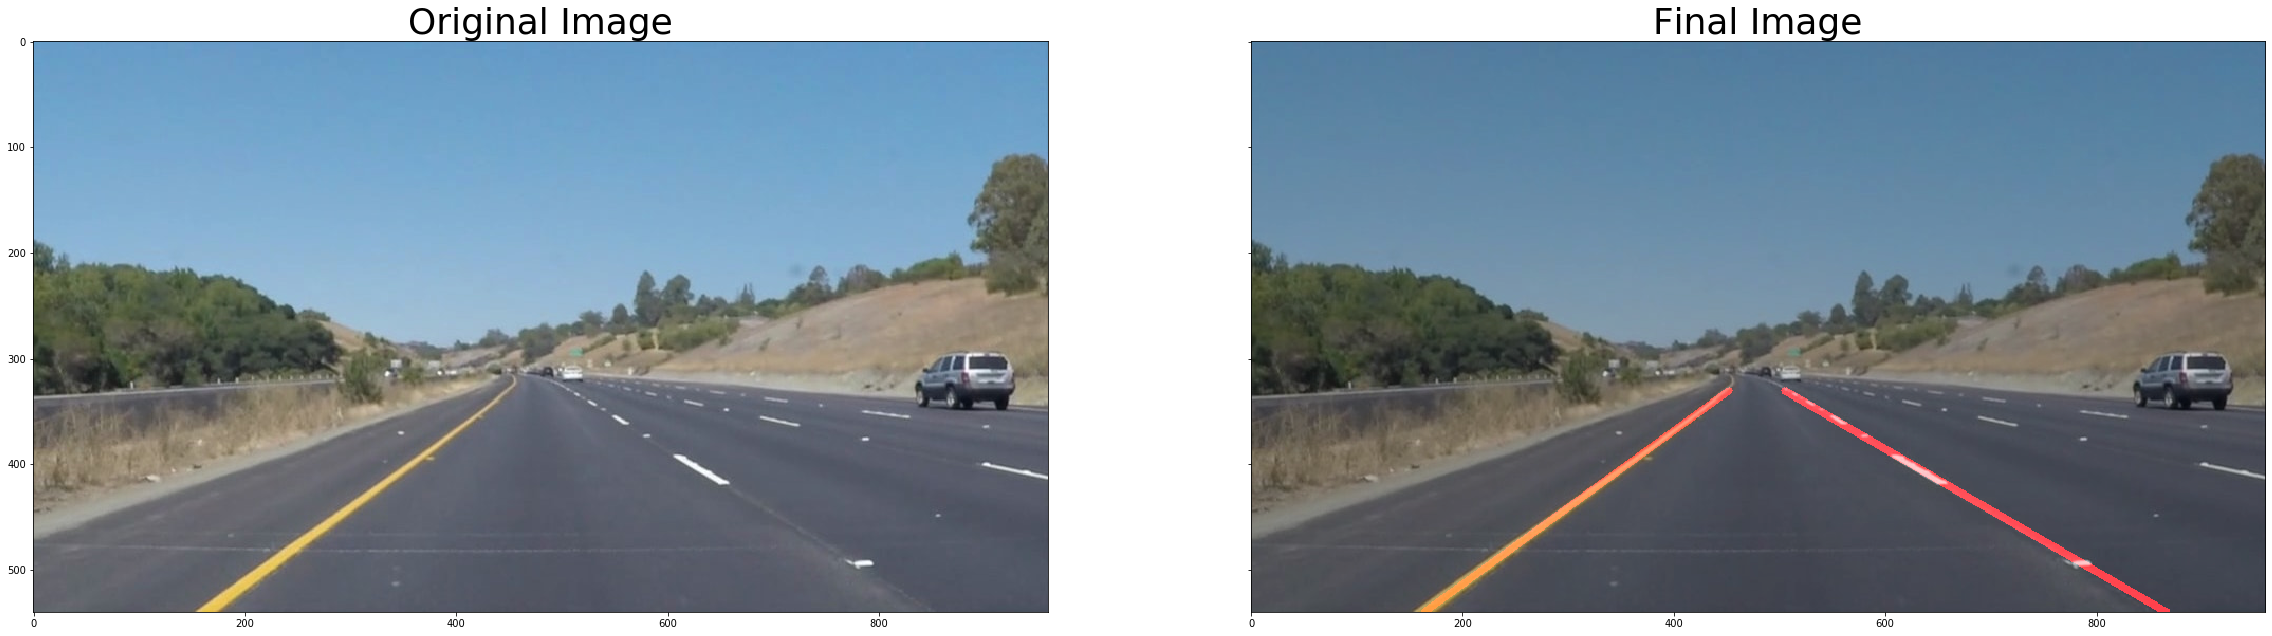

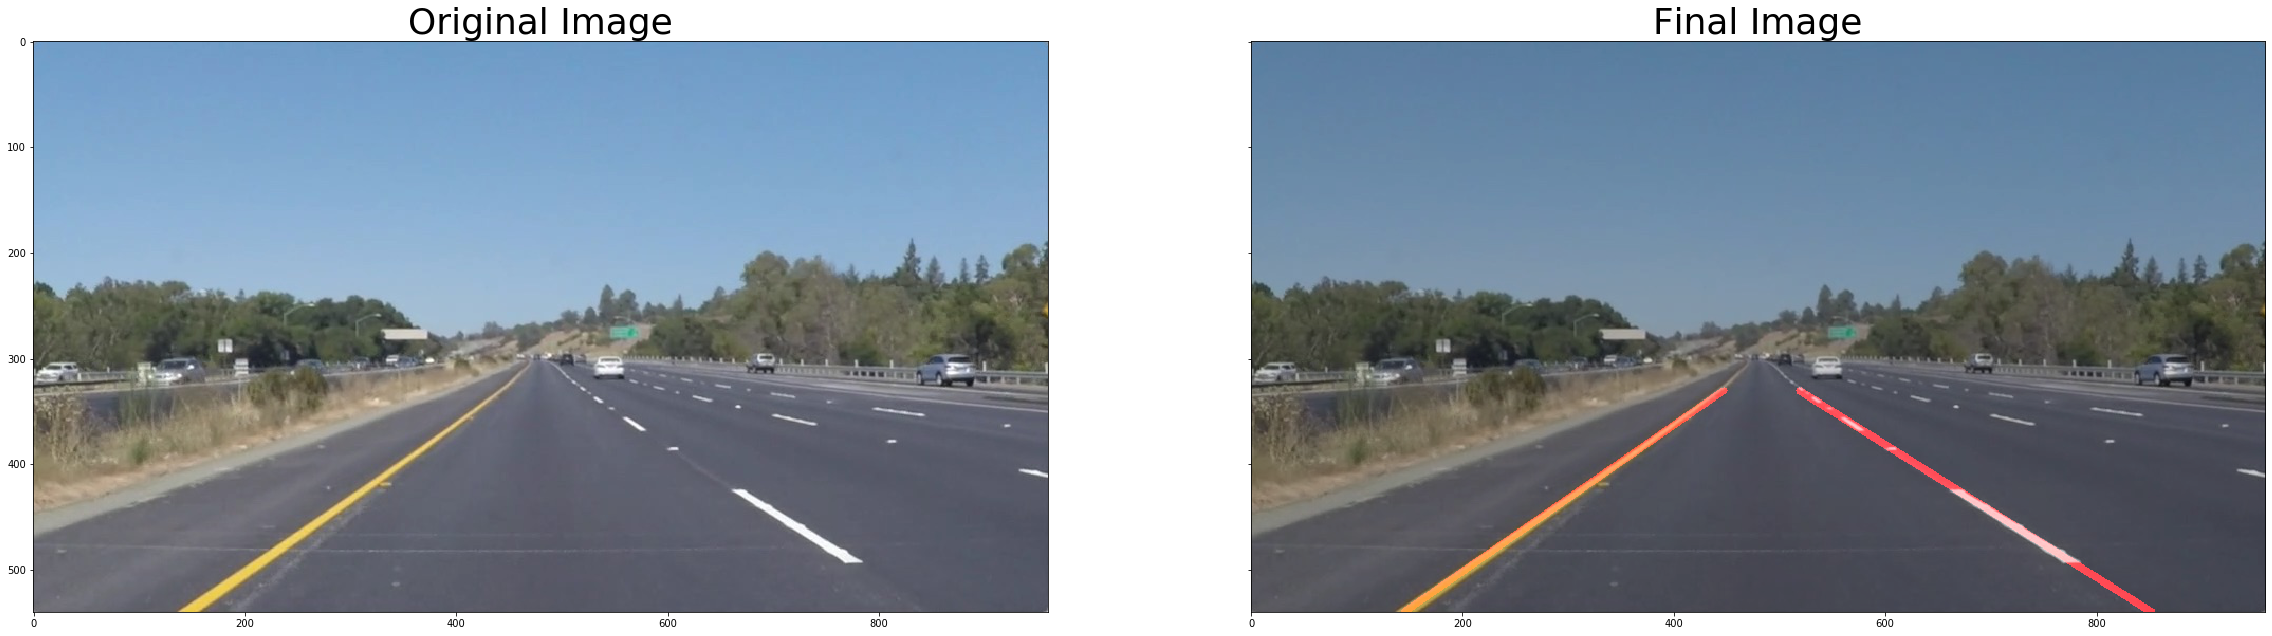

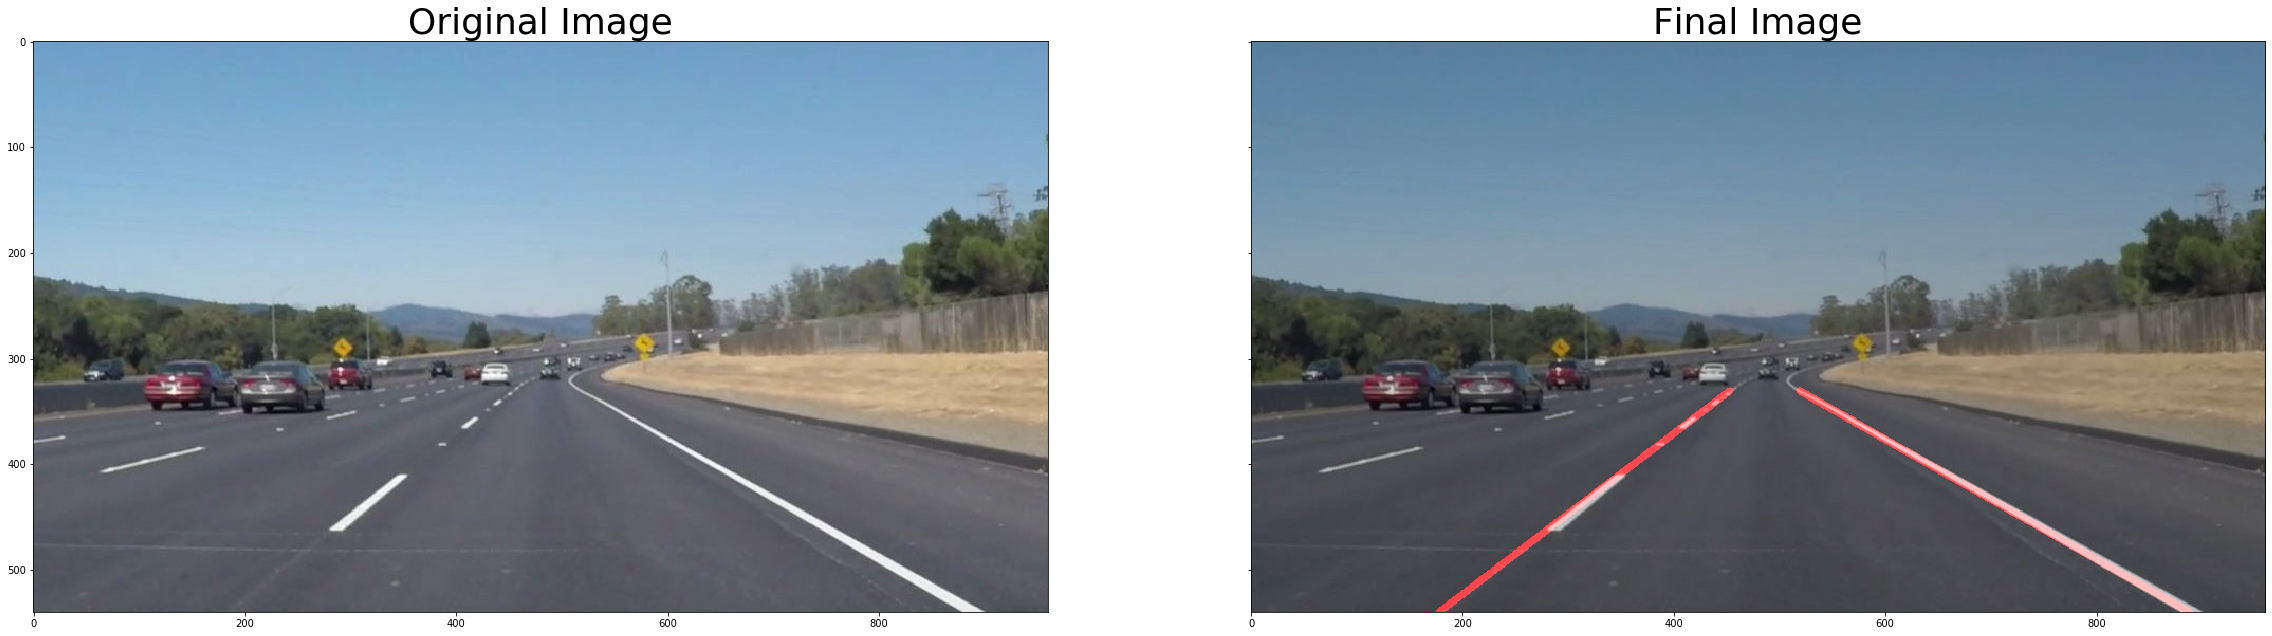

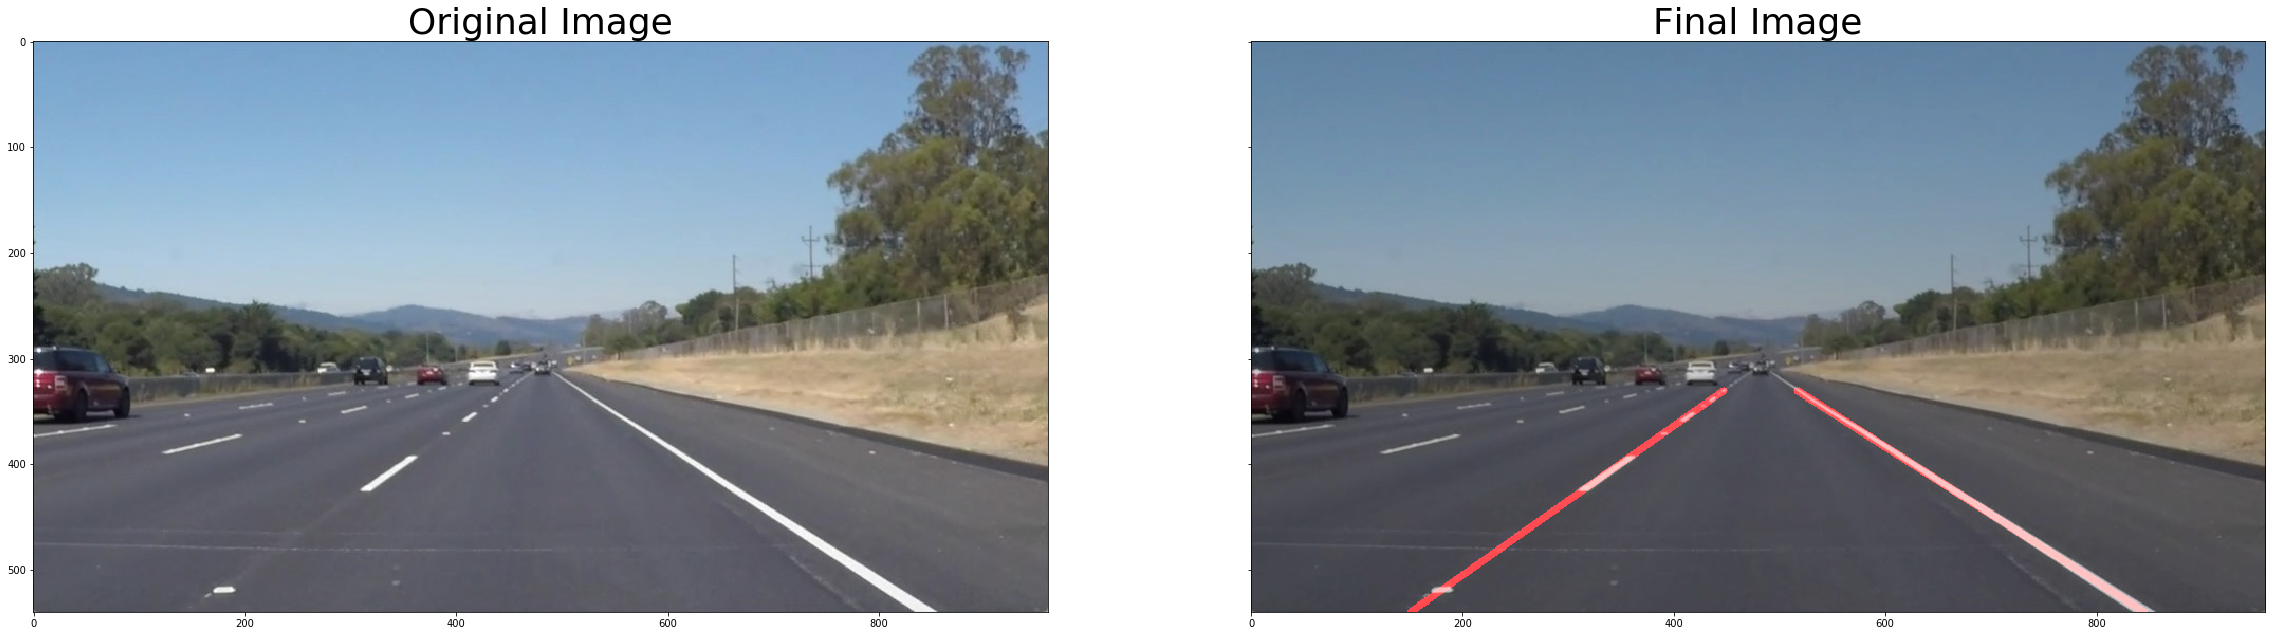

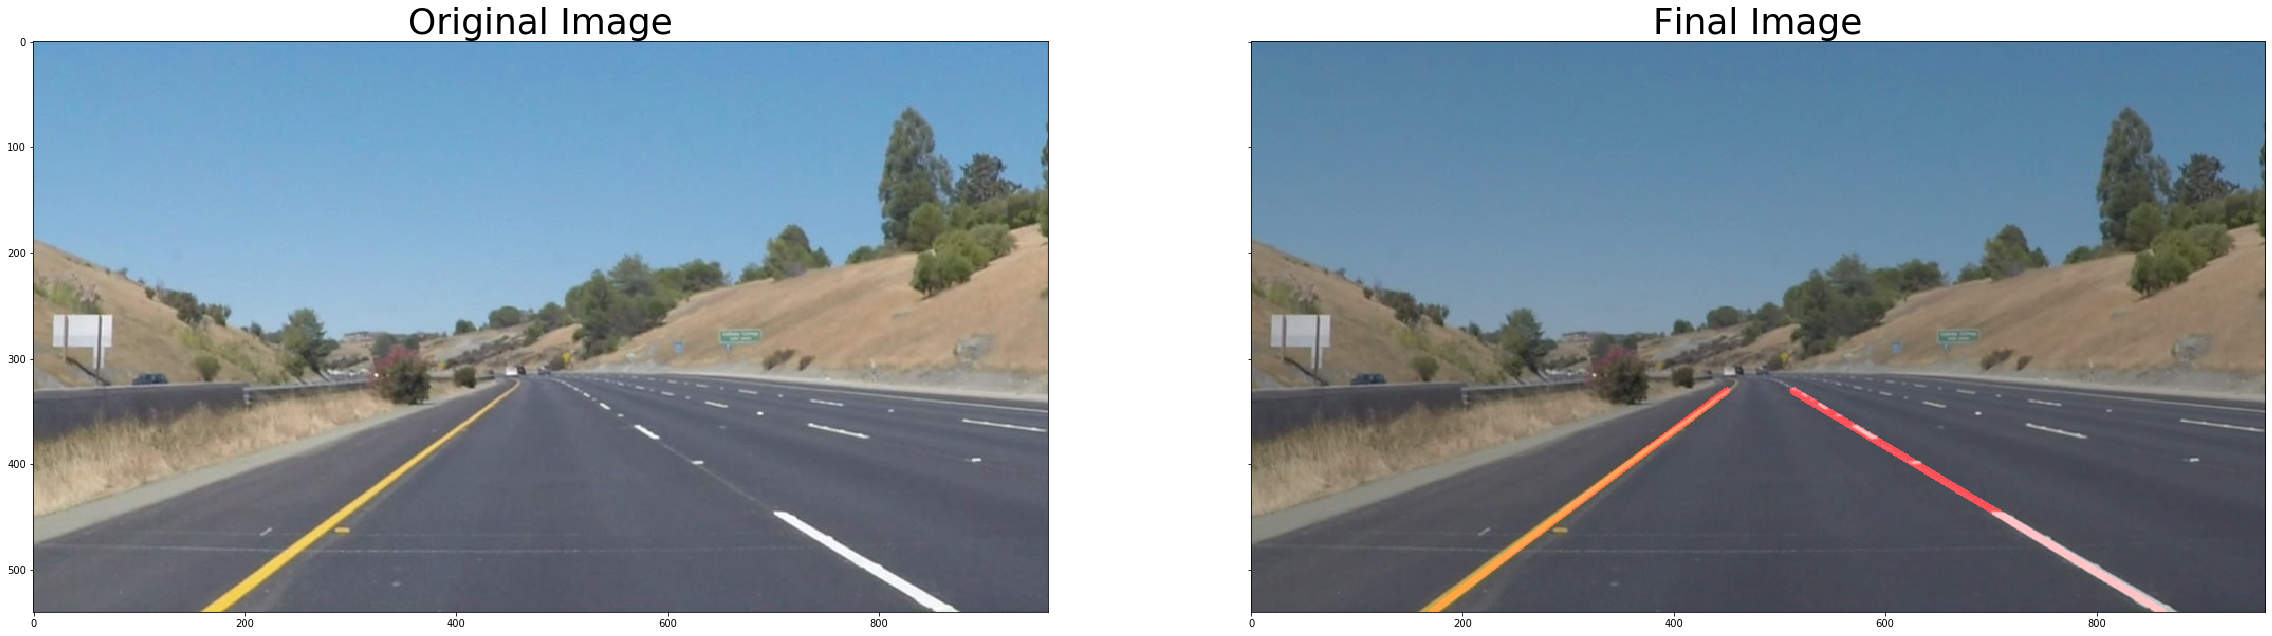

In [4]:
import os
for img_file in os.listdir("test_images/"):
    image = mpimg.imread(f"test_images/{img_file}")
    processed_image = pipeline(image)
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (40, 40))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=36)
    ax2.imshow(processed_image)
    ax2.set_title("Final Image", fontsize=36)
    plt.show()
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    processed_image = pipeline(image)
    return processed_image

## Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   7%|▋         | 15/221 [00:00<00:01, 140.17it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 8.34 s, sys: 231 ms, total: 8.57 s
Wall time: 2.58 s


### Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 13/681 [00:00<00:05, 125.39it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 27.2 s, sys: 788 ms, total: 28 s
Wall time: 7.91 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))